In [1]:
import numpy as np
from rdkit import Chem
from IPython import display
import urllib.request 
import pandas as pd
from rdkit.Chem import AllChem, Draw, Descriptors, PandasTools
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from sklearn import preprocessing
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG

url = 'https://raw.githubusercontent.com/onecoinbuybus/Database_chemoinformatics/master/platinum_dataset.csv'
urllib.request.urlretrieve(url, 'platinum_dataset.csv') 
df = pd.read_csv('platinum_dataset.csv', index_col=0) 
df.shape

(4548, 1)

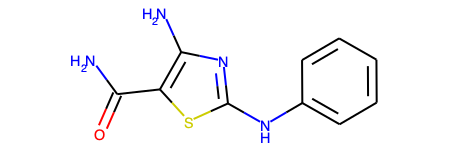

In [2]:
mols=[]
for i in df['smiles']:
    mols.append(Chem.MolFromSmiles(i))

In [40]:
ECFP_bitinfo = {}
ECFP = AllChem.GetMorganFingerprint(mols[11], radius=2, bitInfo=ECFP_bitinfo, useFeatures=False)

In [43]:
def unhash(mols,radius):
    values=[]
    bit_info=[]
    for mol in mols:
        ECFP_bitinfo = {}
        mfp = AllChem.GetMorganFingerprint(mol, radius, bitInfo=ECFP_bitinfo, useFeatures=False)
        values.append(mfp.GetNonzeroElements())
        bit_info.append(ECFP_bitinfo)
    df_mfp = pd.DataFrame.from_dict(values)
    df_mfp.fillna(0., inplace=True)
    return df_mfp,bit_info

In [44]:
unhashed_fp, bit_info=unhash(mols, 2)
unhashed_fp.head()

In [5]:
unhashed_fp.head()

,74537039,98513984,511093476,715187599,799458913,847961216,864942730,864942795,951226070,1182622762,...,1204027184,1854512097,1912122940,2085579530,2547231628,1625127573,2117221561,2537608683,2629980621,3774303344
0,1.0,3.0,1.0,1.0,1.0,3.0,4.0,2.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,3.0,0.0,0.0,0.0,0.0,2.0,0.0,6.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,3.0,0.0,0.0,0.0,1.0,3.0,0.0,6.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:


logp=[]
for i in mols:
    logp.append(Descriptors.MolLogP(i))


In [12]:
X_train, X_test, y_train, y_test = train_test_split(unhashed_fp, logp, test_size=0.2)

In [13]:
model = lgb.LGBMRegressor()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(rmse)

0.6303861499804287


In [15]:
%matplotlib inline
import shap
shap.initjs()

In [17]:
explainer = shap.TreeExplainer(model, data=X_train)
shap_values = explainer.shap_values(X_train)

 99%|===================| 3611/3638 [01:01<00:00]        

Int64Index([  74537039,   98513984,  511093476,  715187599,  799458913,
             847961216,  864942730,  864942795,  951226070, 1182622762,
            ...
            1204027184, 1854512097, 1912122940, 2085579530, 2547231628,
            1625127573, 2117221561, 2537608683, 2629980621, 3774303344],
           dtype='int64', length=22880)

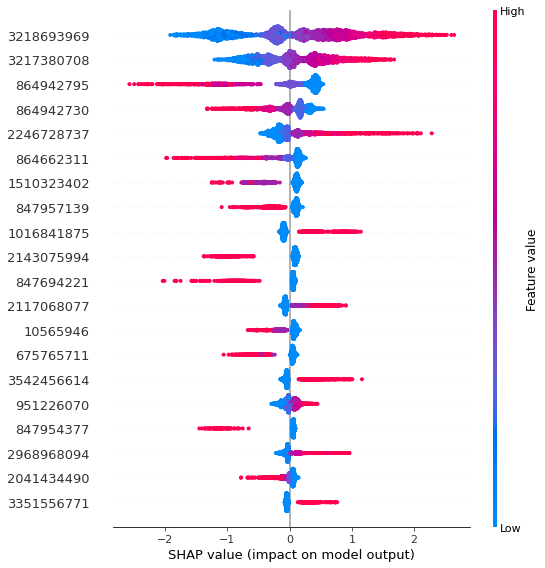

In [21]:
shap.summary_plot(shap_values=shap_values,
                  features=X_train,
                  feature_names=unhashed_fp.columns)

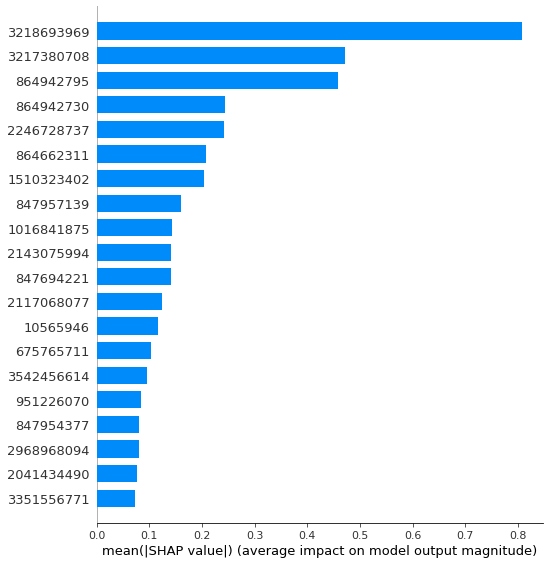

In [22]:
shap.summary_plot(shap_values=shap_values,
                  features=X_train,
                  feature_names=unhashed_fp.columns,
                  plot_type='bar')

In [25]:
X_train.shape

(3638, 22880)

In [30]:
shap_values_df=pd.DataFrame(shap_values, columns=unhashed_fp.columns)

In [70]:
scaled=preprocessing.minmax_scale(shap_values_df[3218693969])

In [71]:
scaled

array([0.84063696, 0.50689626, 0.51217526, ..., 0.79820675, 0.62457535,
       0.15166923])

In [183]:
shap_values_df.head()

,74537039,98513984,511093476,715187599,799458913,847961216,864942730,864942795,951226070,1182622762,...,1204027184,1854512097,1912122940,2085579530,2547231628,1625127573,2117221561,2537608683,2629980621,3774303344
0,0.002654,0.004934,0.0,0.0,0.0,-0.032715,-0.280001,0.417290,0.129923,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.004311,-0.001187,0.0,0.0,0.0,-0.041088,-0.085513,0.378742,0.037722,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.001320,0.005432,0.0,0.0,0.0,0.020884,-0.039371,0.303029,0.135657,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000981,0.006145,0.0,0.0,0.0,0.022691,0.097566,0.346843,0.103095,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.002749,0.007220,0.0,0.0,0.0,0.016383,0.310848,0.430038,-0.013827,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [199]:
bit_info[18]

{43357009: ((1, 2),),
 177068715: ((23, 2),),
 192851103: ((25, 1),),
 203851115: ((16, 1),),
 305828102: ((33, 2),),
 411967733: ((1, 1),),
 485463469: ((34, 1), (35, 1), (36, 1)),
 714893496: ((20, 2),),
 725322217: ((39, 1),),
 747455090: ((11, 2),),
 776782805: ((16, 2),),
 847961216: ((3, 0), (19, 0)),
 864674487: ((7, 0),),
 864942730: ((2, 0), (18, 0)),
 873289723: ((37, 2),),
 882399112: ((34, 0), (35, 0), (36, 0)),
 951226070: ((9, 1), (10, 1), (21, 1), (22, 1)),
 994485099: ((5, 1), (13, 1), (37, 1)),
 1100037548: ((38, 1), (40, 1)),
 1199318220: ((40, 2),),
 1276993226: ((14, 1),),
 1312131881: ((33, 1),),
 1396348621: ((22, 2),),
 1412710081: ((26, 1), (27, 1), (30, 1), (31, 1)),
 1503972698: ((8, 2),),
 1510328189: ((2, 1), (18, 1)),
 1753204072: ((12, 2),),
 1790668568: ((3, 1), (19, 1)),
 1842898132: ((12, 1),),
 1939314357: ((38, 2),),
 2041434490: ((38, 0), (40, 0)),
 2050059121: ((28, 2),),
 2070113494: ((5, 2),),
 2092489639: ((16, 0),),
 2143075994: ((25, 0), (28, 0

In [195]:
def get_info(mol_index, bit_ID, bitinfo,shap_info):
    info=bitinfo[mol_index][bit_ID]
    scaled=preprocessing.minmax_scale(shap_info[bit_ID])
    colour_info=[[cm.viridis(scaled[mol_index])]]*len(info)
    atom_info=[]
    for i in info:
        atom_info.append(i[0])
    colour = dict(zip(atom_info, colour_info))
    
    radius_info=[info[0][1]]*len(info)
    radius = dict(zip(atom_info, radius_info))
    
    return colour, radius

In [196]:
colour, radius = get_info(0, 2246699815, bit_info, shap_values_df)

In [197]:



def frag_shap(colour, radius, mol):
    d2d = rdMolDraw2D.MolDraw2DSVG(600,280,300,280)
    d2d.DrawMoleculeWithHighlights(mol,"98513984",colour,colour,radius,{})
    d2d.FinishDrawing()
    return SVG(d2d.GetDrawingText())

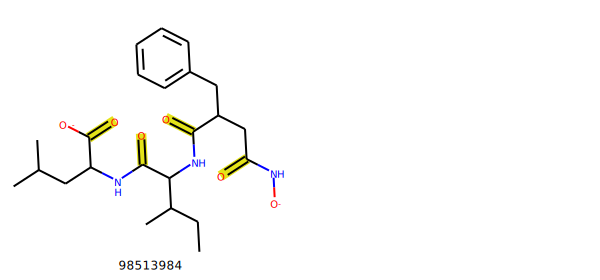

In [198]:
colour, radius = get_info(0, 2246699815, bit_info, shap_values_df)
frag_shap(colour, radius,mols[0])

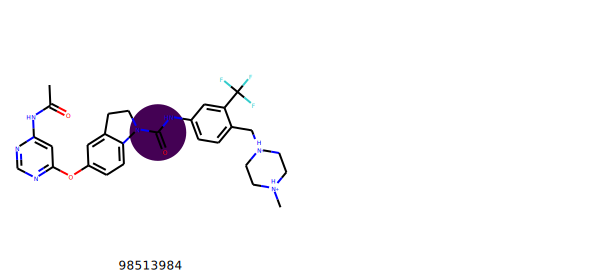

In [202]:
colour, radius = get_info(18, 3638823234, bit_info, shap_values_df)
frag_shap(colour, radius,mols[18])

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

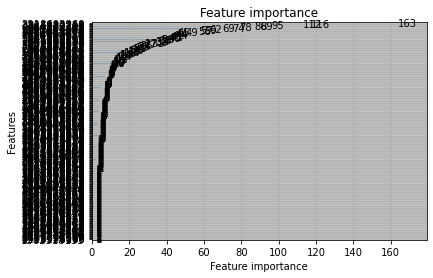

In [186]:
lgb.plot_importance(model)